In [1]:
import matplotlib.pyplot as plt
from plots.mpltoolkit import named_colors, fancy_legend, load_style_sheet, mpl_loc
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import get_velocity_profile
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
def mw_stellar_surface_density_profile(radius):
    sigma_0_thin = 1115e6
    sigma_0_thick = 300e6
    rs_thin = 2.5
    rs_thick = 2.0
    return sigma_0_thin * np.exp(-radius / rs_thin) + sigma_0_thick * np.exp(-radius / rs_thick)

In [71]:
output = vice.output("../outputs/test")

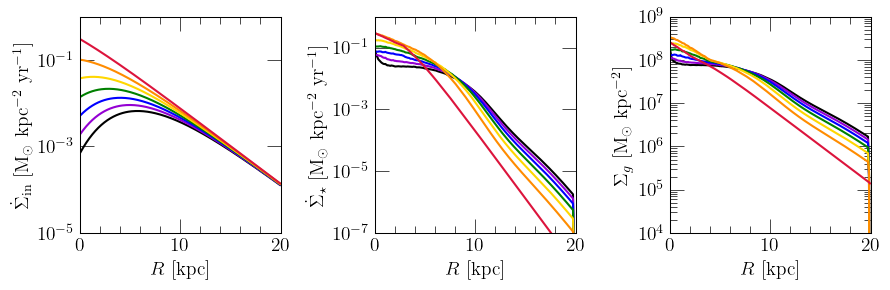

In [72]:
LOOKBACKS = [0, 2, 4, 6, 8, 10, 12.2]
COLORS = ["black", "darkviolet", "blue", "green", "gold", "darkorange", "crimson"]
# LOOKBACKS = [11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

fig = plt.figure(figsize = (9, 3))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(r"$R$ [kpc]")
    axes[i].set_yscale("log")
    axes[i].set_xlim([0, 20])
axes[0].set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[1].set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[2].set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]")
axes[0].set_ylim([1.e-5, 1])
axes[1].set_ylim([1.0e-7, 1.0])
axes[2].set_ylim([1.0e4, 1.0e9])

def plot_snapshot(ax_ifr, ax_sfr, ax_gas, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    sigma_ifr = []
    sigma_sfr = []
    sigma_gas = []
    for i in range(len(output.zones.keys())):
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        zone = output.zones["zone%d" % (i)]
        sigma_ifr.append(zone.history["ifr"][idx] / area)
        sigma_sfr.append(zone.history["sfr"][idx] / area)
        sigma_gas.append(zone.history["mgas"][idx] / area)
    ax_ifr.plot(radii, sigma_ifr, **kwargs)
    ax_sfr.plot(radii, sigma_sfr, **kwargs)
    ax_gas.plot(radii, sigma_gas, **kwargs)

for i in range(len(LOOKBACKS)):
    kwargs = {"c": named_colors()[COLORS[i]]}
    plot_snapshot(*axes, output, LOOKBACKS[i], **kwargs)

plt.tight_layout()
plt.show()

6.629e+10
2.747e+10


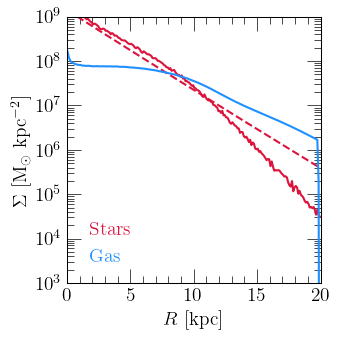

In [73]:
fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R$ [kpc]")
ax.set_ylabel(r"$\Sigma$ [M$_\odot$ kpc$^{-2}$]")
ax.set_xlim([0, 20])
ax.set_ylim([1.0e3, 1.0e9])
ax.set_yscale("log")

radii = [0.1 * (i + 0.5) for i in range(200)]
target = [mw_stellar_surface_density_profile(r) for r in radii]
ax.plot(radii, target, c = named_colors()["crimson"], linestyle = "--")

def plot_results(output, zone_width = 0.1, which = "stars", **kwargs):
    radii = []
    sigma = []
    mass = 0
    for i in range(len(output.zones.keys())):
        radii.append(zone_width * (i + 0.5))
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        if which == "stars":
            m = output.zones["zone%d" % (i)].history["mstar"][-1]
        elif which == "gas":
            m = output.zones["zone%d" % (i)].history["mgas"][-1]
        else:
            raise ValueError("Bruh")
        sigma.append(m / area)
        mass += m
    print("%.3e" % (mass))
    ax.plot(radii, sigma, **kwargs)

plot_results(output, c = named_colors()["crimson"], label = "Stars")
plot_results(output, which = "gas", c = named_colors()["dodgerblue"], label = "Gas")

# ax.axhline(1.0e7, c = named_colors()["black"])

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "dodgerblue"])

plt.tight_layout()
plt.show()

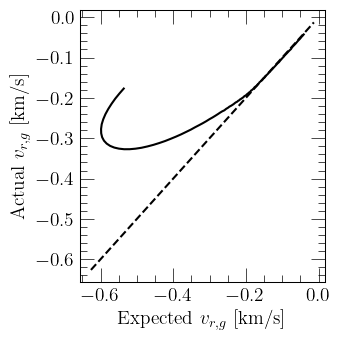

In [61]:
# LOOKBACKS = [0, 2, 4, 6, 8, 10]
# COLORS = ["black", "darkviolet", "blue", "green", "gold", "crimson"]
LOOKBACKS = [0]
COLORS = ["black"]

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Expected $v_{r,g}$ [km/s]")
ax.set_ylabel(r"Actual $v_{r,g}$ [km/s]")
# ax.set_xlim([-4, 0])
# ax.set_ylim(ax.get_xlim())

def expected_velocities(output, lookback, v_circ_ratio_in = 0.8, v_circ_ratio_out = 0, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    velocities = []
    for i in range(len(output.zones.keys())):
        radius = zone_width * (i + 0.5)
        zone = output.zones["zone%d" % (i)]
        v = zone.history["ofr"][idx] / zone.history["mgas"][idx] * 1.0e9 * (1 - v_circ_ratio_out)
        v -= zone.history["ifr"][idx] / zone.history["mgas"][idx] * 1.0e9 * (1 - v_circ_ratio_in)
        v *= radius
        velocities.append(v)
    return velocities

def plot_predictions(output, lookback, v_circ_ratio_in = 0.8, v_circ_ratio_out = 0, zone_width = 0.1, **kwargs):
    expected = expected_velocities(output, lookback,
        v_circ_ratio_in = v_circ_ratio_in,
        v_circ_ratio_out = v_circ_ratio_out,
        zone_width = zone_width)
    radii, actual = get_velocity_profile(output, lookback)
    # for i in range(len(radii)):
    #     if abs(radii[i] / actual[i] - 1) > 1: print(i)
    # for i in range(len(radii)):
    #     print(radii[i], expected[i], actual[i])
    # ax.plot(expected[110:120], actual[110:120], **kwargs)
    ax.plot(expected[30:150], actual[30:150], **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"%g Gyr ago" % (LOOKBACKS[i])
    }
    plot_predictions(output, LOOKBACKS[i], **kwargs)

# ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), c = named_colors()["black"], linestyle = "--")
plt.tight_layout()
plt.show()